In [0]:
!pip install numpy
!pip install pandas 
!pip install python-louvain
!pip install networkx
!pip install nxviz

### Helper functions

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from community import best_partition, modularity

from scipy.cluster.hierarchy import linkage,dendrogram,fcluster

from collections import Counter
from IPython.core.pylabtools import figsize

In [0]:
def louvain(G,return_json = True):
    community = [comm for node, comm in best_partition(G).items()]
    if return_json:
        return json.dumps([{'node':int(i),'community':int(comm)} for i,comm in enumerate(community)],ensure_ascii = False)
    else:
        return community
    
def draw_community(G,comm_id,comm):
    nodes = [k for k,v in dict(zip(list(G.nodes()),comm)).items() if v == comm_id]
    S = G.subgraph(nodes)
    bipartite = [1  if n.startswith('M') else 2 for n in nodes]
    nx.draw(S,node_color = bipartite,cmap = plt.get_cmap('Set2'))
    plt.show()
    
    
def draw_bipartite(T,with_labels = False):
    bipartite = [1 if n.startswith('M') else 2 for n in T.nodes()]
    nx.draw(T,node_color = bipartite,cmap=plt.get_cmap('Set2'),with_labels = with_labels,pos = nx.spring_layout(T),alpha = 0.6)

    
def add_similary_group(T = None,n_merchants = 7, n_accounts = 50,edges = 250):
    
    if not T:
        T = nx.Graph()
    
    accounts = [n for n in T.nodes() if n.startswith('A')]
    merchants = [n for n in T.nodes() if n.startswith('M')]
    edgelist = list(T.edges())
    
    merchants_added = ["M" + str(i + len(merchants)+1) for i in range(n_merchants)]
    accounts_added = ['A' + str(i+ len(accounts)+1) for i in range(n_accounts)]
    
    edgelist += [(np.random.choice(accounts_added),np.random.choice(merchants_added)) for _ in range(edges)]
    
    return nx.from_edgelist(edgelist)

def add_random_edge(T,links = 100):
    links = 100
    edges_added = list(zip(np.random.choice([n for n in T.nodes() if n.startswith('A')],size = links),np.random.choice([n for n in T.nodes() if n.startswith('M')],size = links)))
    return nx.from_edgelist(list(T.edges())+edges_added)

### Fraud case simulation based on real world observations

- M as merchant node，A as personal account node
- M1 - M7 is densely connected through A1 - A20  
- M8 - M18 is loosely connected ghrough A21 - A121   
- ...     
- ...     
- Add random connection to ensure complexity    
- Aiming to find community with M1 - M7 included    

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


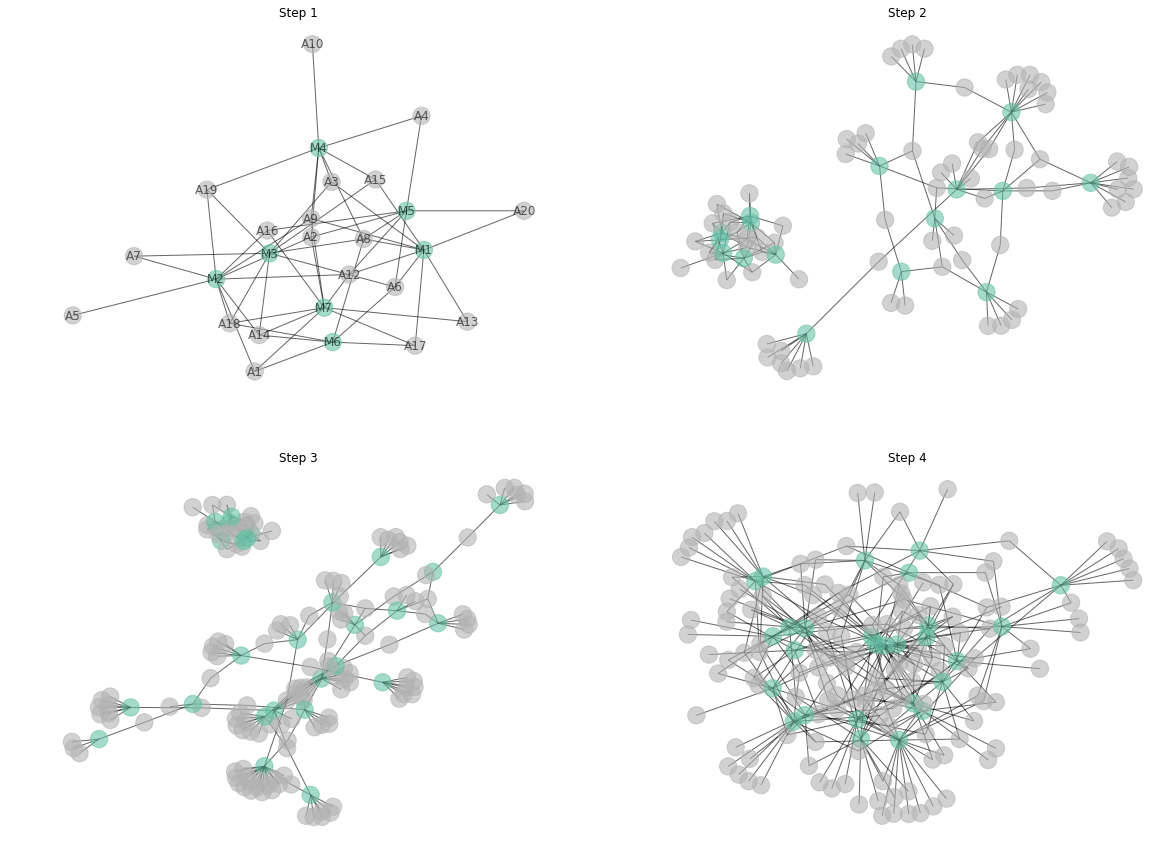

In [0]:
figsize(20,15)
T = add_similary_group(n_merchants = 7,n_accounts = 20, edges = 75)
plt.subplot(2,2,1)
plt.title("Step 1")
draw_bipartite(T,with_labels = True)


T = add_similary_group(T,10,100,80)
plt.subplot(2,2,2)
plt.title("Step 2")
draw_bipartite(T)


T = add_similary_group(T,10,300,80)
plt.subplot(2,2,3)
plt.title("Step 3")
draw_bipartite(T)

# T = add_similary_group(T,20,300,80)
# plt.subplot(2,2,3)
# plt.title("Step 3")
# draw_bipartite(T)


T = add_random_edge(T,100)
plt.subplot(2,2,4)
plt.title("Step 4")
draw_bipartite(T)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


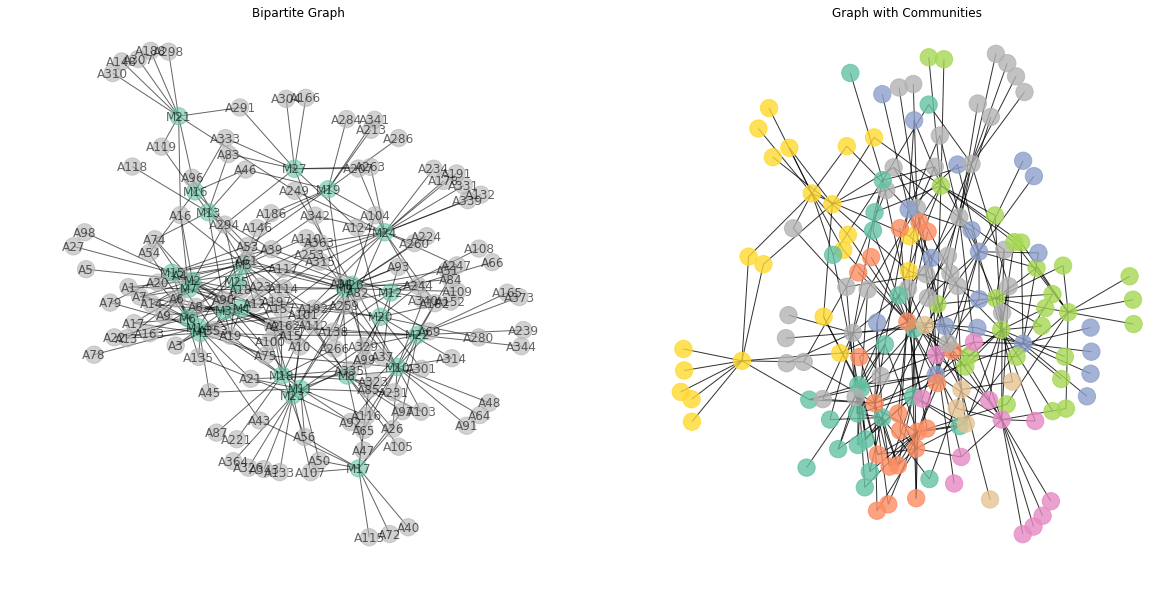

In [0]:
figsize(20,10)
plt.subplot(1,2,1)
draw_bipartite(T,with_labels = True)
plt.title("Bipartite Graph")

comm = louvain(T,return_json=False)

plt.subplot(1,2,2)
plt.title("Graph with Communities")
nx.draw(T,node_color = comm,cmap = plt.get_cmap('Set2'),alpha = 0.8)

### Community Detection Summary

The logic of suspicous community is defined as follows:

Merchant Density = # merchant nodes within community / # nodes within community

In [0]:
summary = pd.DataFrame([(n[0],c) for n, c in list(zip(T.nodes(),comm))],columns = ['node_type','comm']).\
pivot_table(index =[ 'comm'],columns = 'node_type',values = 'comm',aggfunc = lambda x:len(x))
summary['score'] = summary['M'] / (summary['A'] + summary['M'])
summary.sort_values(by = 'score',ascending = False)

node_type,A,M,score
comm,,,
0,19,5,0.208333
1,17,4,0.190476
3,10,2,0.166667
6,5,1,0.166667
4,22,4,0.153846
2,17,3,0.150000
8,12,2,0.142857
5,19,3,0.136364
7,19,3,0.136364


/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


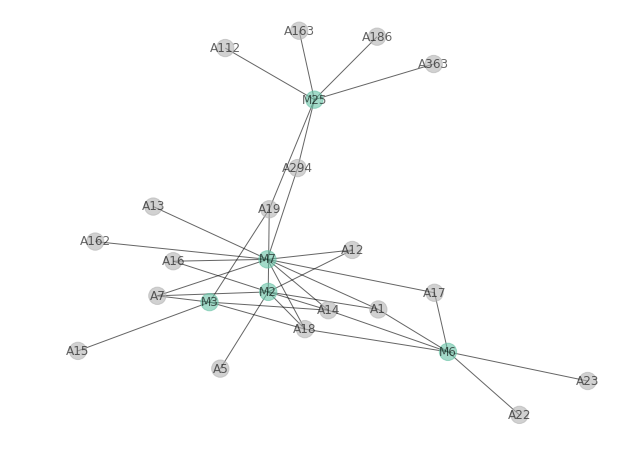

In [0]:
figsize(8,6)
comm_nodes = [n for i,n in enumerate(T.nodes()) if comm[i] ==0]
S = T.subgraph(comm_nodes)
draw_bipartite(S,with_labels = True)

In [0]:
print("Suspicuous Merchants: ",[n for n in comm_nodes if n.startswith('M')])

Suspicuous Merchants:  ['M7', 'M6', 'M2', 'M3', 'M25']


Okay, fine, WTF

### Investigate other suspicuous patterns

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


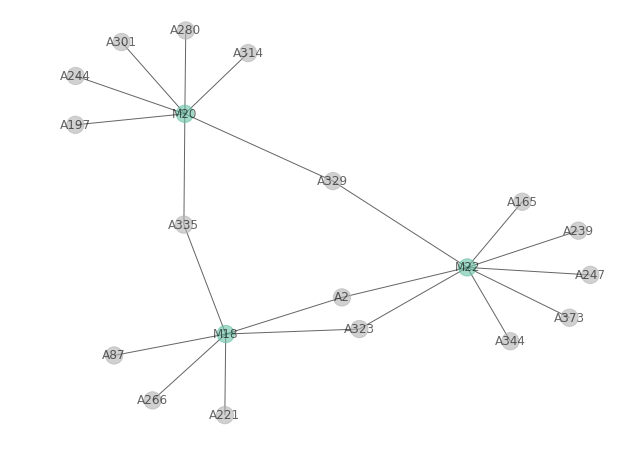

In [0]:
figsize(8,6)
comm_nodes = [n for i,n in enumerate(T.nodes()) if comm[i] ==2]
S = T.subgraph(comm_nodes)
draw_bipartite(S,with_labels = True)

### What about centrality based algorithms

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


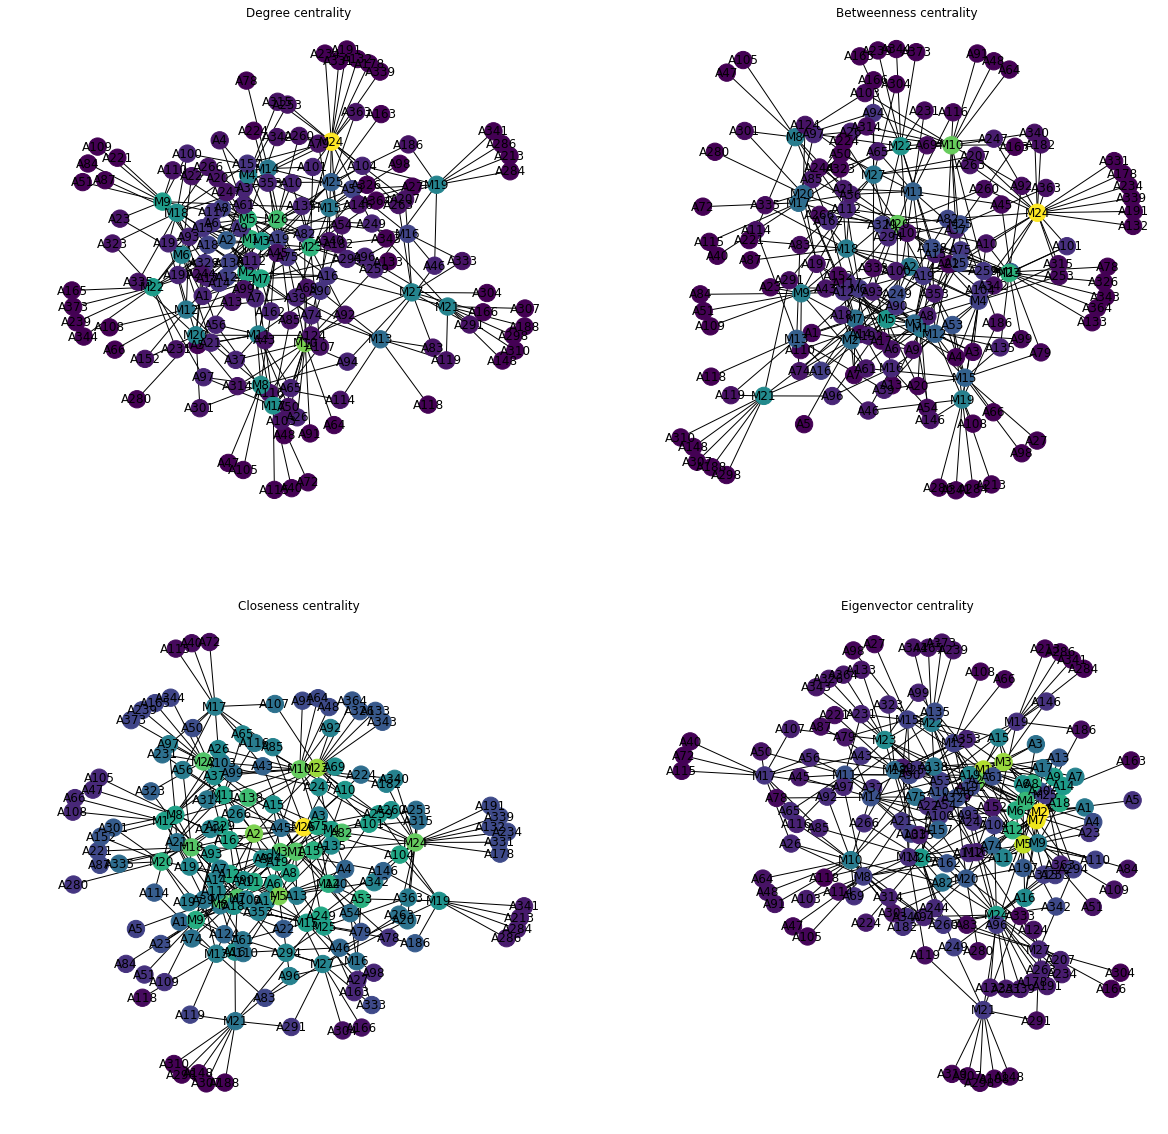

In [0]:
ecent = nx.eigenvector_centrality(T)
dcent = nx.degree_centrality(T)
bcent = nx.betweenness_centrality(T)
ccent = nx.closeness_centrality(T)
# print('Super connection nodes',sorted(bcent,key = bcent.get,reverse = True)[0:25])
figsize(20,20)
plt.subplot(2,2,1)
nx.draw(T,node_color = list(dcent.values()),with_labels = True)
plt.title("Degree centrality")
plt.subplot(2,2,2)
nx.draw(T,node_color = list(bcent.values()),with_labels = True)
plt.title("Betweenness centrality")
plt.subplot(2,2,3)
nx.draw(T,node_color = list(ccent.values()),with_labels = True)
plt.title("Closeness centrality")
plt.subplot(2,2,4)
nx.draw(T,node_color = list(ecent.values()),with_labels = True)
plt.title('Eigenvector centrality')
plt.show()

### Simrank, Regular equivalence and Role detection

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


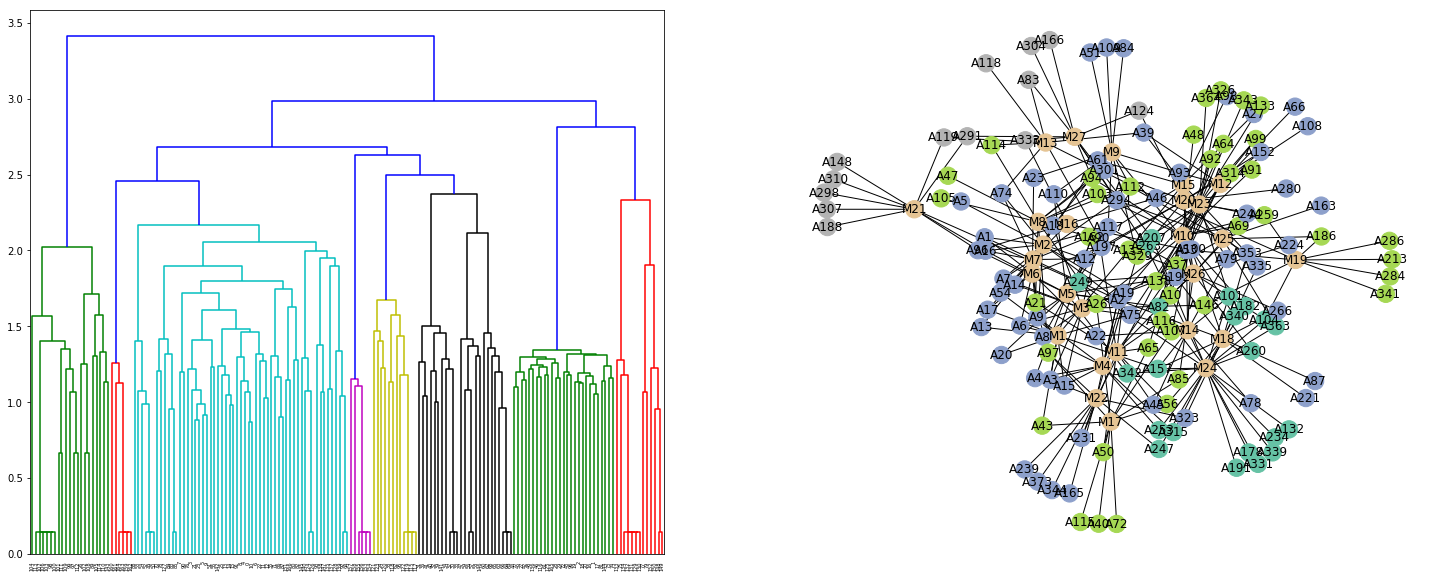

In [0]:
def simrank_similarity_numpy(G, source=None, target=None, importance_factor=0.9, max_iterations=100, tolerance=1e-4):
    
    # adjacency matrix
    adjacency_matrix = nx.to_numpy_array(G)
    
    # normalization and ensure not divide by 0
    adjacency_matrix /= adjacency_matrix.sum(axis=0) + 1e-3
    
    # identity matrix
    newsim = np.eye(adjacency_matrix.shape[0], dtype=np.float64)
    
    # iterate
    for _ in range(max_iterations):
        prevsim = np.copy(newsim)
        newsim = importance_factor * np.matmul(
            np.matmul(adjacency_matrix.T, prevsim), adjacency_matrix)
        np.fill_diagonal(newsim, 1.0)

        if np.allclose(prevsim, newsim, atol=tolerance):
            break

    if source is not None and target is not None:
        return newsim[source, target]
    if source is not None:
        return newsim[source]
    return newsim

def most_similar_n_nodes(node,sigma,n = 3):
    return np.flip(np.argsort(sigma[node,:])[-1-n:-1].tolist())


def test_on_graph(G,n_clust = 3):
    
    sigma = simrank_similarity_numpy(G)
    mergin = linkage(sigma,method = 'complete')
    clusters =  fcluster(mergin,n_clust,'maxclust')
    
    plt.subplot(1,2,1)
    dendro = dendrogram(mergin)
    
    plt.subplot(1,2,2)
    nx.draw(G,node_color = clusters,with_labels = True,cmap = plt.get_cmap('Set2'))
    plt.show()
    return sigma,mergin

figsize(25,10)
sigma,mergin = test_on_graph(T,5)
lookup = {n:i for i, n in enumerate(list(T.nodes()))}
reverse_lookup = {v:k for k,v in lookup.items()}

In [0]:
noi_str = 'M1'
noi = lookup[noi_str] # node of interest
num_similar_nodes = 10
print('Most similar nodes to {} (structral):'.format(noi_str))
[reverse_lookup[node] for node in most_similar_n_nodes(noi,sigma,num_similar_nodes)]

Most similar nodes to M1 (structral):


['M3', 'M4', 'M7', 'M6', 'M5', 'M2', 'M14', 'M16', 'M22', 'M15']

### Graph Projection and Bipartite Graph

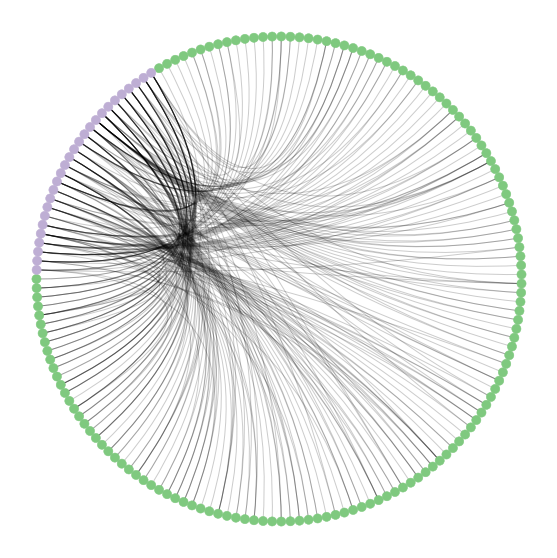

In [0]:
# add bipartite property to a graph

for n,d in T.nodes(data = True):
    if n.startswith('A'):
        d['bipartite'] = 'account'
    elif n.startswith('M'):
        d['bipartite'] = 'merchant'
    else:
        pass

import nxviz as nv
circ = nv.CircosPlot(T,node_color = 'bipartite',node_order = 'bipartite',figsize = (10,10))
circ.draw()

In [0]:
merchant_nodes = [n for n,d in T.nodes(data = True) if d['bipartite'] == 'merchant']
account_nodes = [n for n,d in T.nodes(data = True) if d['bipartite'] == 'account']
adj_mat = nx.bipartite.biadjacency_matrix(T,row_order=merchant_nodes,column_order=account_nodes).toarray()

projected_merchant = adj_mat @ adj_mat.T

### Bipartite adjacency matrix

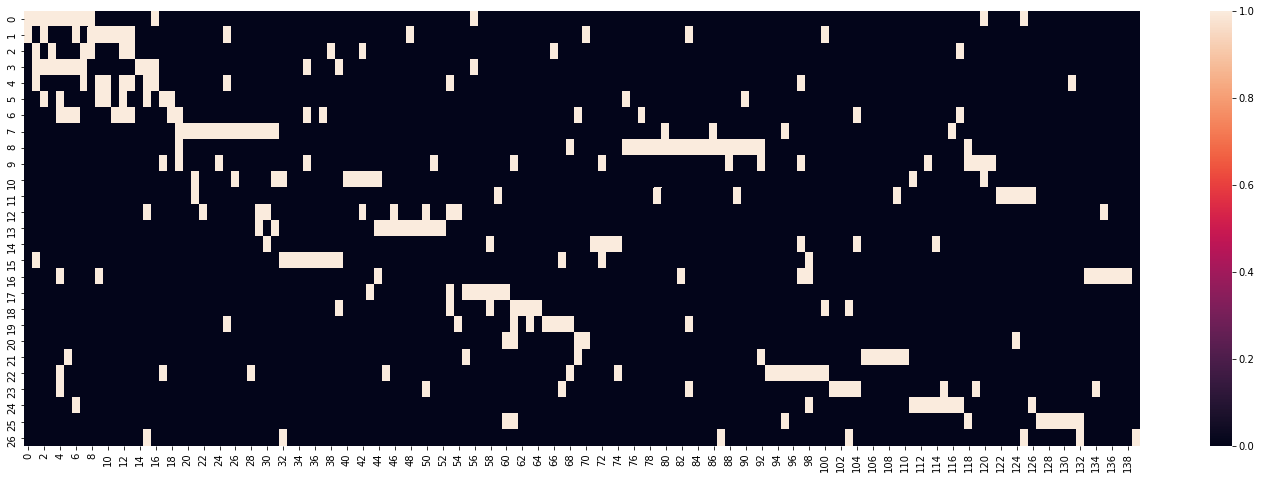

In [0]:
figsize(25,8)
sns.heatmap(adj_mat)
plt.show()

### Projected adjacency matrix - on merchant nodes

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


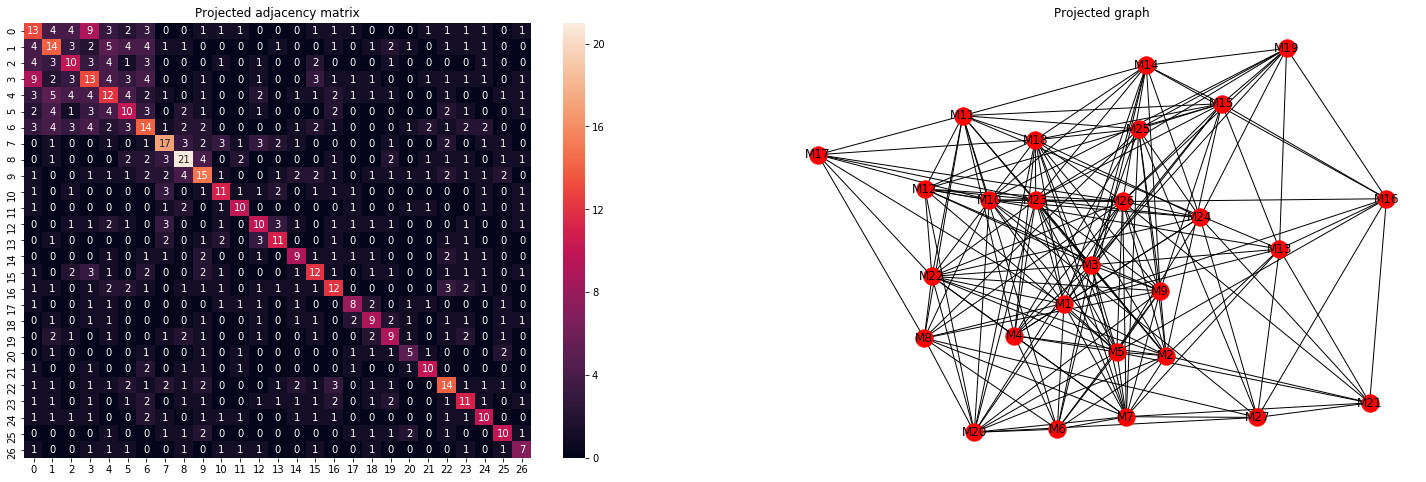

In [0]:
figsize(25,8)
plt.subplot(1,2,1)
sns.heatmap(projected_merchant,annot = True)
plt.title("Projected adjacency matrix")


G = nx.from_numpy_matrix(projected_merchant)
G = nx.from_edgelist([(merchant_nodes[u],merchant_nodes[v],d) for u,v,d  in G.edges(data = True)])
plt.subplot(1,2,2)
nx.draw(G,with_labels = True)
plt.title('Projected graph')
plt.show()

### Community Detection on projected graph

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


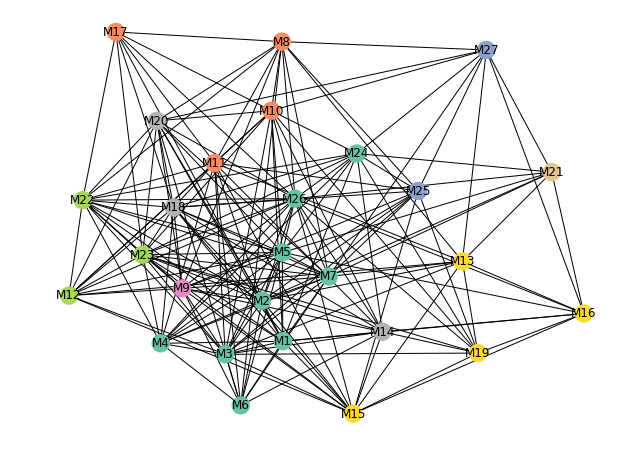

In [0]:
figsize(8,6)
community = [comm for node, comm in best_partition(G,weight='weight').items()]
nx.draw(G,node_color = community,with_labels = True,cmap = plt.get_cmap('Set2'))

In [0]:
pd.DataFrame(zip(G.nodes(),community),columns = ['Node Set','Community']).pivot_table(index = 'Community',values = 'Node Set',aggfunc = lambda x:list(x))

,Node Set
Community,
0,"[M7, M1, M6, M2, M3, M4, M5]"
1,"[M26, M24]"
2,"[M8, M10, M17, M11]"
3,"[M27, M25]"
4,[M9]
5,"[M22, M23, M12]"
6,"[M13, M15, M16, M19]"
7,[M21]
8,"[M18, M14]"


**Okey roughly the same result as original graph**